# Training a neural network with McSnow autoconversion output

This script applies a DNN to the regression problem to find Phi_au(tau) of Seifert and Beheng (2001)

Here it is tested with a Log transform of data and predictors is helpful. In short: it is!

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


### Load Tensorflow and other useful modules

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [2]:
tf.random.set_seed(1234)

### Load data from netcdf

In [3]:
import numpy as np
import xarray as xr

In [4]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="big_n5"
fname1=mdir+edir+'autocon_train_'+data+'.nc'
fname2=mdir+edir+'autocon_test_'+data+'.nc'
fname3=mdir+edir+'autocon_val_big_n2.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:     (i: 6, ii: 6, j: 7, jj: 7, k: 5, kk: 5, n: 5, nn: 5, nt: 4000)
Coordinates:
  * n           (n) int32 0 1 2 3 4
  * i           (i) int32 200 400 600 800 1000 2000
  * j           (j) int32 9 10 11 12 13 14 15
  * k           (k) int32 0 1 2 3 4
Dimensions without coordinates: ii, jj, kk, nn, nt
Data variables:
    time        (n, i, j, k, nt) float32 ...
    tau         (n, i, j, k, nt) float32 ...
    Lc          (n, i, j, k, nt) float32 ...
    Nc          (n, i, j, k, nt) float32 ...
    Zc          (n, i, j, k, nt) float32 ...
    Lr          (n, i, j, k, nt) float32 ...
    Nr          (n, i, j, k, nt) float32 ...
    Zr          (n, i, j, k, nt) float32 ...
    nu          (n, i, j, k, nt) float32 ...
    mue         (n, i, j, k, nt) float64 ...
    nue         (n, i, j, k, nt) float64 ...
    auto_num    (n, i, j, k, nt) float32 ...
    auto_mass   (n, i, j, k, nt) float32 ...
    accr_num    (n, i, j, k, nt) float32 ...
    accr_mass   (n

# Prepare data for training

In [5]:
def read_and_prepare_data(fname,ZERO):
    # Read some data, we just want simple nparrays. Hence the .values
    tau  = xr.open_dataset(fname).tau.values
    auto = xr.open_dataset(fname).auto_mass.values
    accr = xr.open_dataset(fname).accr_mass.values
    selfr = xr.open_dataset(fname).self_rain.values
    selfc = xr.open_dataset(fname).self_cloud.values
    Lc   = xr.open_dataset(fname).Lc.values
    Lr   = xr.open_dataset(fname).Lr.values
    Nc   = xr.open_dataset(fname).Nc.values
    Nr   = xr.open_dataset(fname).Nr.values
    nu   = xr.open_dataset(fname).nu.values
    # some numerical lower bounds
    L_min = 1e-15
    N_min = 1e-15
    tau_min  = 1e-15
    auto_min = 1e-15
    # lower bound on autoconversion based on input
    auto = np.where(auto>ZERO, auto, np.nan*auto)
    # transform everything except nu in log space
    Xc = np.log(Lc/Nc, where=Nc>N_min)
    Xr = np.log(Lr/Nr, where=Nr>N_min)
    Nc = np.log(Nc, where=Nc>N_min)
    Nr = np.log(Nr, where=Nr>N_min)
    Lc = np.log(Lc, where=Lc>L_min)
    Lr = np.log(Lr, where=Lr>L_min)
    tau  = np.log(tau, where=tau>tau_min, out=np.nan*tau)    
    auto = np.log(auto, where=auto>auto_min, out=np.nan*auto)
    accr = np.log(accr, where=accr>auto_min, out=np.nan*accr)
    selfr = np.log(selfr, where=selfr>auto_min, out=np.nan*selfr)
    selfc = np.log(selfc, where=selfc>auto_min, out=np.nan*selfc)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ auto.ravel(), accr.ravel(), selfc.ravel(), selfr.ravel(), Lc.ravel(), Xc.ravel(), Nc.ravel(), Lr.ravel(), Xr.ravel(), Nr.ravel(), nu.ravel() ]))
    dataset = dataset.T
    dataset.columns = ['auto','accr','selfc','selfr','Lc','Xc','Nc','Lr','Xr','Nr','nu'] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [6]:
ZERO=1e-12
Zstring=-np.log10(ZERO)

data=data+'_z%d'%Zstring    

dataset_train = read_and_prepare_data(fname1,ZERO)
dataset_test = read_and_prepare_data(fname2,ZERO)
dataset_val = read_and_prepare_data(fname3,ZERO)

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/pyt

### Inspect the data

In [7]:
dataset_train.head()

auto       accr     selfc      selfr        Lc         Xc  \
344 -23.952938 -24.457457  6.583181 -15.162584 -8.522467 -26.460238   
348 -27.008099 -23.431816  5.297692 -15.648092 -8.522487 -26.459875   
349 -25.140886 -24.031610  6.458368 -14.360238 -8.522492 -26.459671   
353 -26.177179 -23.905104  4.918695 -17.727533 -8.522512 -26.459257   
354 -25.451662 -23.727608  6.662805 -10.206758 -8.522517 -26.459005   

            Nc         Lr         Xr        Nr   nu  
344  17.937771 -16.649040 -21.313763  4.664721  0.0  
348  17.937387 -16.577154 -21.253649  4.676495  0.0  
349  17.937178 -16.561876 -21.246902  4.685025  0.0  
353  17.936745 -16.505926 -21.208977  4.703050  0.0  
354  17.936489 -16.488857 -21.197927  4.709071  0.0

In [8]:
dataset_test.head()

auto       accr     selfc      selfr        Lc         Xc  \
303 -24.820036 -24.672716  6.952968 -11.380144 -8.113807 -26.451429   
304 -26.277121 -24.642570  5.992012 -17.727533 -8.113807 -26.451342   
312 -24.819223 -24.634418  7.072710 -17.727533 -8.113827 -26.449331   
322 -23.074625 -23.657539  7.262432 -17.727533 -8.113860 -26.446470   
323 -25.902302 -23.865486  7.083253 -11.102141 -8.113864 -26.446213   

            Nc         Lr         Xr        Nr   nu  
303  18.337622 -17.747797 -21.447889  3.700091  0.5  
304  18.337534 -17.723875 -21.431223  3.707348  0.5  
312  18.335505 -17.469637 -21.379795  3.910157  0.5  
322  18.332611 -17.144039 -21.277727  4.133687  0.5  
323  18.332348 -17.117165 -21.257666  4.140501  0.5

In [9]:
dataset_train.describe()

auto           accr          selfc          selfr  \
count  157586.000000  157586.000000  157586.000000  157586.000000   
mean      -21.486502     -17.071617       6.354106      -1.478037   
std         2.826198       2.255488       2.334663       5.707967   
min       -27.630852     -27.579996     -14.293547     -17.727533   
25%       -23.571993     -18.556329       5.144904      -4.024383   
50%       -21.277900     -16.890870       6.633179       0.405205   
75%       -19.325706     -15.388234       8.003467       2.514949   
max       -13.795737     -11.982386      11.287971       8.206409   

                  Lc             Xc             Nc             Lr  \
count  157586.000000  157586.000000  157586.000000  157586.000000   
mean       -8.303328     -25.736496      17.437563     -10.320187   
std         1.073201       0.512274       1.150774       2.403249   
min       -14.710634     -28.268673      11.050814     -20.693756   
25%        -8.761376     -26.123384      16.732211     -12.148037   
50%        -8.313967     -25.816530      17.516932      -9.957234   
75%        -7.472261     -25.339688      18.250502      -8.300186   
max        -6.215789     -24.881920      20.245541      -6.217086   

                  Xr             Nr             nu  
count  157586.000000  157586.000000  157586.000000  
mean      -18.927074       8.606781       1.918787  
std         2.124871       1.573649       1.395136  
min       -22.034079       0.919470       0.000000  
25%       -20.689145       7.542385       1.000000  
50%       -19.410274       8.626649       2.000000  
75%       -17.519808       9.731326       3.000000  
max       -10.602690      13.366846       4.000000

In [10]:
dataset_test.describe()

auto           accr          selfc          selfr  \
count  102251.000000  102251.000000  102251.000000  102251.000000   
mean      -21.310019     -16.798435       6.621704      -1.230046   
std         2.747854       2.165580       2.272831       5.660765   
min       -27.630722     -26.158291     -10.436559     -17.727533   
25%       -23.289943     -18.190001       5.751750      -3.591417   
50%       -21.025661     -16.367603       7.028538       0.726500   
75%       -19.189130     -15.180819       8.145212       2.713744   
max       -14.564456     -12.561091      10.677000       7.404851   

                  Lc             Xc             Nc             Lr  \
count  102251.000000  102251.000000  102251.000000  102251.000000   
mean       -8.173966     -25.732601      17.559637     -10.172183   
std         1.062508       0.499927       1.159604       2.435260   
min       -14.928525     -28.042217      11.582536     -19.182032   
25%        -8.566163     -26.119614      16.946279     -12.031308   
50%        -8.115712     -25.815695      17.716476      -9.663490   
75%        -7.444825     -25.337846      18.324710      -8.156309   
max        -6.503551     -24.882586      19.943756      -6.504339   

                  Xr             Nr             nu  
count  102251.000000  102251.000000  102251.000000  
mean      -18.789951       8.617681       1.965824  
std         2.183631       1.563370       1.109884  
min       -22.032505       2.284380       0.500000  
25%       -20.636971       7.550695       0.500000  
50%       -19.251991       8.640534       1.500000  
75%       -17.271407       9.783873       2.500000  
max       -10.191885      12.864232       3.500000

### Further reduce data to relevant parameter range for autoconversion

In [11]:
def reduce_data(dataset):
    idx = dataset[ dataset['Lc'] < np.log(1e-9) ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [12]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

In [13]:
dataset_train.describe()

auto           accr          selfc          selfr  \
count  157586.000000  157586.000000  157586.000000  157586.000000   
mean      -21.486502     -17.071617       6.354106      -1.478037   
std         2.826198       2.255488       2.334663       5.707967   
min       -27.630852     -27.579996     -14.293547     -17.727533   
25%       -23.571993     -18.556329       5.144904      -4.024383   
50%       -21.277900     -16.890870       6.633179       0.405205   
75%       -19.325706     -15.388234       8.003467       2.514949   
max       -13.795737     -11.982386      11.287971       8.206409   

                  Lc             Xc             Nc             Lr  \
count  157586.000000  157586.000000  157586.000000  157586.000000   
mean       -8.303328     -25.736496      17.437563     -10.320187   
std         1.073201       0.512274       1.150774       2.403249   
min       -14.710634     -28.268673      11.050814     -20.693756   
25%        -8.761376     -26.123384      16.732211     -12.148037   
50%        -8.313967     -25.816530      17.516932      -9.957234   
75%        -7.472261     -25.339688      18.250502      -8.300186   
max        -6.215789     -24.881920      20.245541      -6.217086   

                  Xr             Nr             nu  
count  157586.000000  157586.000000  157586.000000  
mean      -18.927074       8.606781       1.918787  
std         2.124871       1.573649       1.395136  
min       -22.034079       0.919470       0.000000  
25%       -20.689145       7.542385       1.000000  
50%       -19.410274       8.626649       2.000000  
75%       -17.519808       9.731326       3.000000  
max       -10.602690      13.366846       4.000000

In [14]:
dataset_test.describe()

auto           accr          selfc          selfr  \
count  102251.000000  102251.000000  102251.000000  102251.000000   
mean      -21.310019     -16.798435       6.621704      -1.230046   
std         2.747854       2.165580       2.272831       5.660765   
min       -27.630722     -26.158291     -10.436559     -17.727533   
25%       -23.289943     -18.190001       5.751750      -3.591417   
50%       -21.025661     -16.367603       7.028538       0.726500   
75%       -19.189130     -15.180819       8.145212       2.713744   
max       -14.564456     -12.561091      10.677000       7.404851   

                  Lc             Xc             Nc             Lr  \
count  102251.000000  102251.000000  102251.000000  102251.000000   
mean       -8.173966     -25.732601      17.559637     -10.172183   
std         1.062508       0.499927       1.159604       2.435260   
min       -14.928525     -28.042217      11.582536     -19.182032   
25%        -8.566163     -26.119614      16.946279     -12.031308   
50%        -8.115712     -25.815695      17.716476      -9.663490   
75%        -7.444825     -25.337846      18.324710      -8.156309   
max        -6.503551     -24.882586      19.943756      -6.504339   

                  Xr             Nr             nu  
count  102251.000000  102251.000000  102251.000000  
mean      -18.789951       8.617681       1.965824  
std         2.183631       1.563370       1.109884  
min       -22.032505       2.284380       0.500000  
25%       -20.636971       7.550695       0.500000  
50%       -19.251991       8.640534       1.500000  
75%       -17.271407       9.783873       2.500000  
max       -10.191885      12.864232       3.500000

### Pairplot

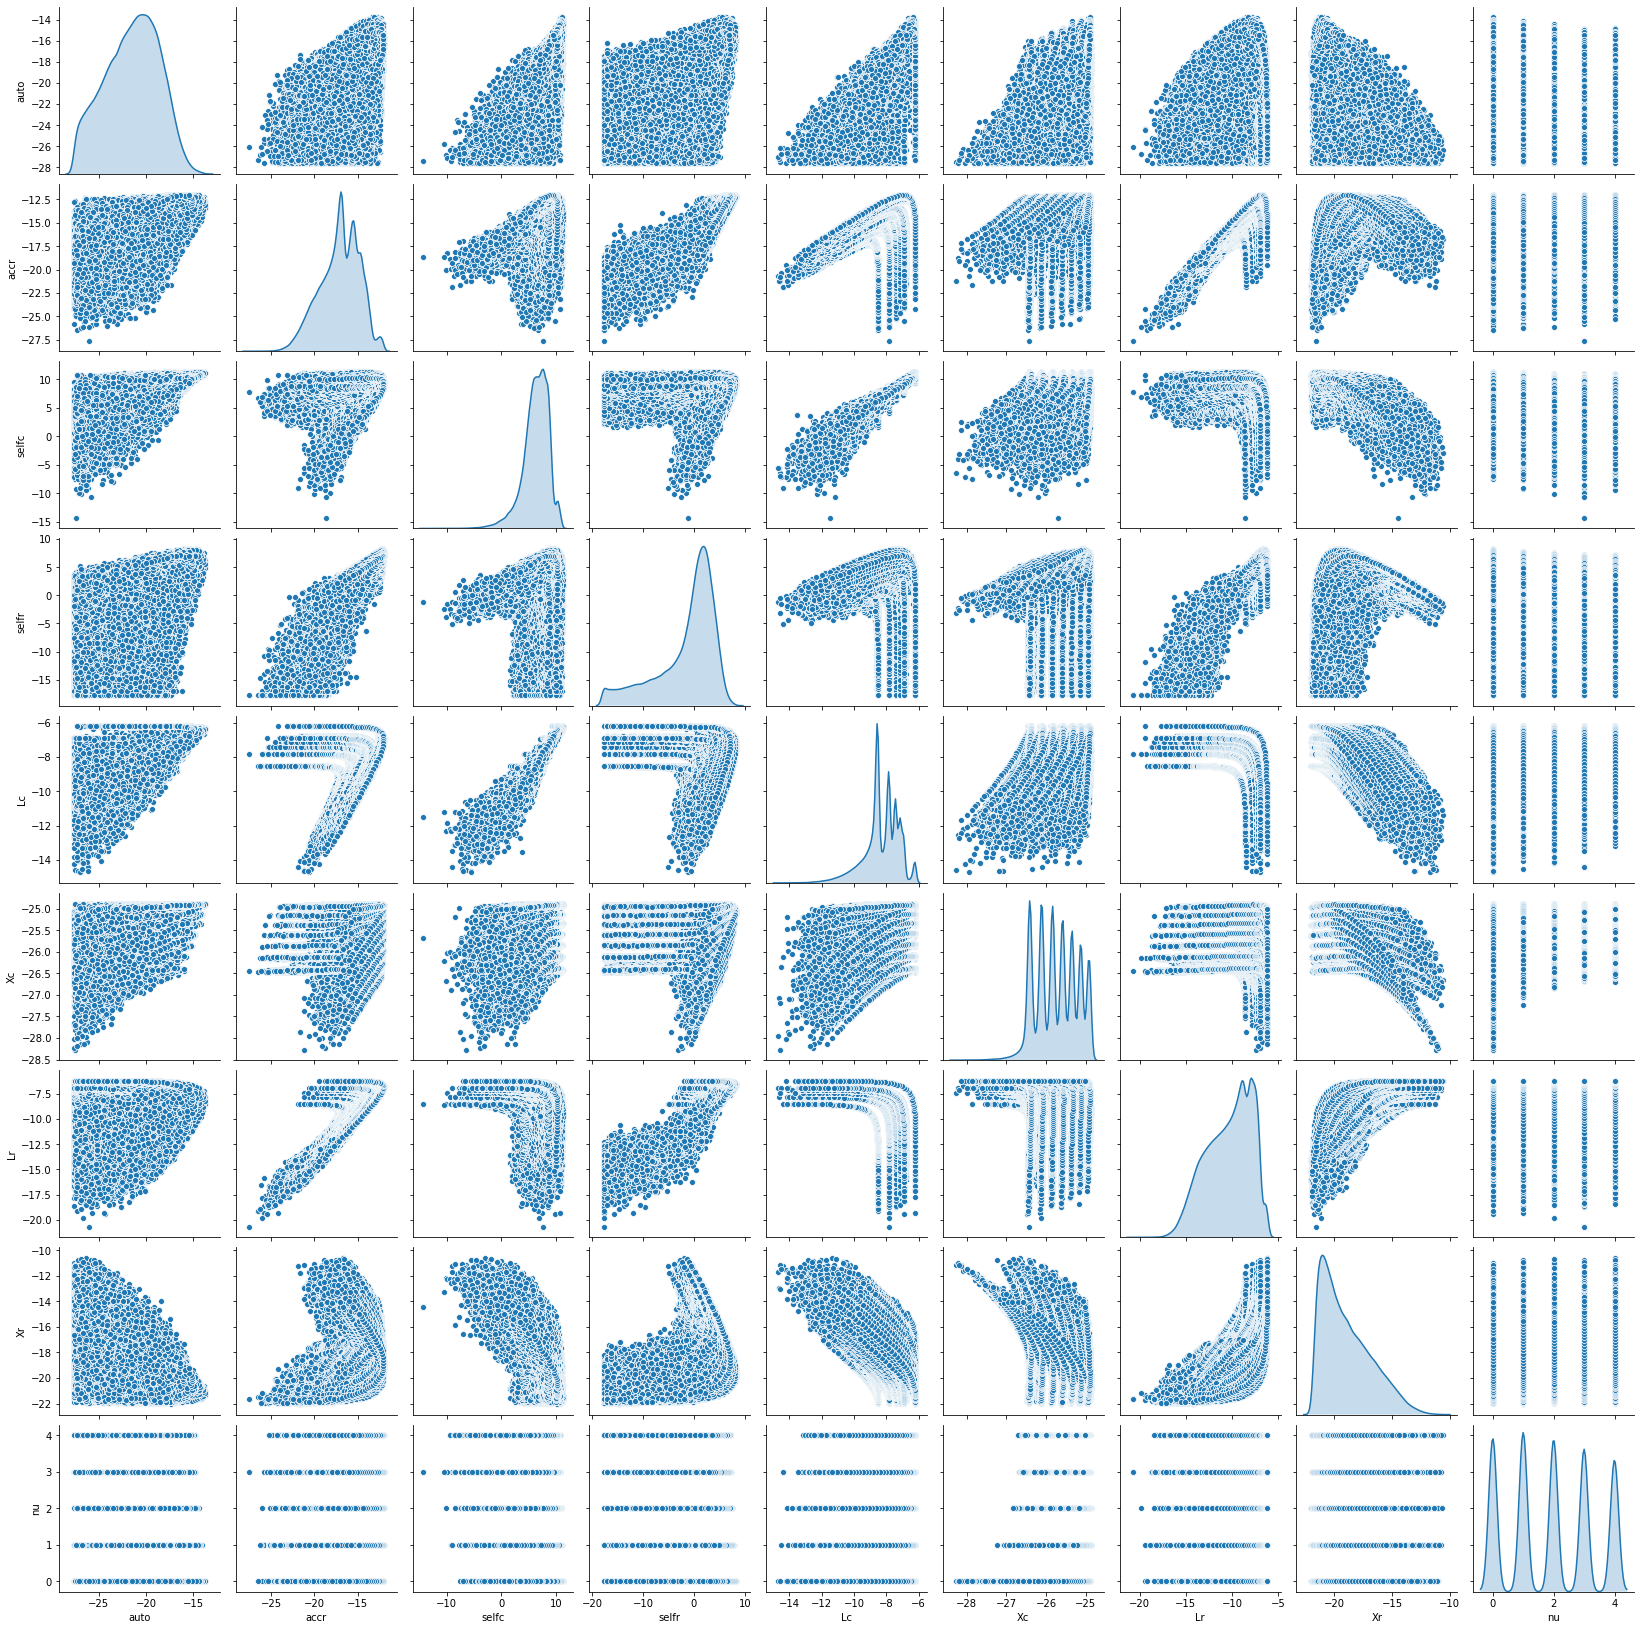

In [15]:
sns.pairplot(dataset_train[["auto","accr","selfc","selfr","Lc","Xc","Lr","Xr",'nu']], diag_kind="kde")

## Separate in different dataset with selected sets of predictors

In [16]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [17]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [18]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [19]:
train_dataset1 = train_dataset1.drop(['Nc','Nr'], axis=1)
train_dataset2 = train_dataset2.drop(['Xc','Xr'], axis=1)
train_dataset3 = train_dataset3.drop(['Lc','Lr'], axis=1)

In [20]:
test_dataset1 = test_dataset1.drop(['Nc','Nr'], axis=1)
test_dataset2 = test_dataset2.drop(['Xc','Xr'], axis=1)
test_dataset3 = test_dataset3.drop(['Lc','Lr'], axis=1)

In [21]:
val_dataset1 = val_dataset1.drop(['Nc','Nr'], axis=1)
val_dataset2 = val_dataset2.drop(['Xc','Xr'], axis=1)
val_dataset3 = val_dataset3.drop(['Lc','Lr'], axis=1)

In [22]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("auto")
train_stats1.pop("accr")
train_stats1.pop("selfc")
train_stats1.pop("selfr")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%        75%  \
Lc  157586.0  -8.303328  1.073201 -14.710634  -8.761376  -8.313967  -7.472261   
Xc  157586.0 -25.736496  0.512274 -28.268673 -26.123384 -25.816530 -25.339688   
Lr  157586.0 -10.320187  2.403249 -20.693756 -12.148037  -9.957234  -8.300186   
Xr  157586.0 -18.927074  2.124871 -22.034079 -20.689145 -19.410274 -17.519808   
nu  157586.0   1.918787  1.395136   0.000000   1.000000   2.000000   3.000000   

          max  
Lc  -6.215789  
Xc -24.881920  
Lr  -6.217086  
Xr -10.602690  
nu   4.000000

In [23]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("auto")
train_stats2.pop("accr")
train_stats2.pop("selfc")
train_stats2.pop("selfr")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min        25%        50%        75%  \
Lc  157586.0  -8.303328  1.073201 -14.710634  -8.761376  -8.313967  -7.472261   
Nc  157586.0  17.437563  1.150774  11.050814  16.732211  17.516932  18.250502   
Lr  157586.0 -10.320187  2.403249 -20.693756 -12.148037  -9.957234  -8.300186   
Nr  157586.0   8.606781  1.573649   0.919470   7.542385   8.626649   9.731326   
nu  157586.0   1.918787  1.395136   0.000000   1.000000   2.000000   3.000000   

          max  
Lc  -6.215789  
Nc  20.245541  
Lr  -6.217086  
Nr  13.366846  
nu   4.000000

In [24]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("auto")
train_stats3.pop("accr")
train_stats3.pop("selfc")
train_stats3.pop("selfr")
train_stats3 = train_stats3.transpose()
train_stats3

count       mean       std        min        25%        50%        75%  \
Xc  157586.0 -25.736496  0.512274 -28.268673 -26.123384 -25.816530 -25.339688   
Nc  157586.0  17.437563  1.150774  11.050814  16.732211  17.516932  18.250502   
Xr  157586.0 -18.927074  2.124871 -22.034079 -20.689145 -19.410274 -17.519808   
Nr  157586.0   8.606781  1.573649   0.919470   7.542385   8.626649   9.731326   
nu  157586.0   1.918787  1.395136   0.000000   1.000000   2.000000   3.000000   

          max  
Xc -24.881920  
Nc  20.245541  
Xr -10.602690  
Nr  13.366846  
nu   4.000000

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [25]:
# pop does not work for multiply columns, use copy instead

train_labels1 = train_dataset1[['auto','accr','selfc','selfr']].copy()
train_dataset1.drop(['auto','accr','selfc','selfr'], axis=1, inplace=True)

test_labels1 = test_dataset1[['auto','accr','selfc','selfr']].copy()
test_dataset1.drop(['auto','accr','selfc','selfr'], axis=1, inplace=True)

val_labels1 = val_dataset1[['auto','accr','selfc','selfr']].copy()
val_dataset1.drop(['auto','accr','selfc','selfr'], axis=1, inplace=True)

In [26]:
train_labels2 = train_dataset2[['auto','accr','selfc','selfr']].copy()
train_dataset2.drop(['auto','accr','selfc','selfr'], axis=1, inplace=True)

test_labels2 = test_dataset2[['auto','accr','selfc','selfr']].copy()
test_dataset2.drop(['auto','accr','selfc','selfr'], axis=1, inplace=True)

val_labels2 = val_dataset2[['auto','accr','selfc','selfr']].copy()
val_dataset2.drop(['auto','accr','selfc','selfr'], axis=1, inplace=True)

In [27]:
train_labels3 = train_dataset3[['auto','accr','selfc','selfr']].copy()
train_dataset3.drop(['auto','accr','selfc','selfr'], axis=1, inplace=True)

test_labels3 = test_dataset3[['auto','accr','selfc','selfr']].copy()
test_dataset3.drop(['auto','accr','selfc','selfr'], axis=1, inplace=True)

val_labels3 = val_dataset3[['auto','accr','selfc','selfr']].copy()
val_dataset3.drop(['auto','accr','selfc','selfr'], axis=1, inplace=True)

In [28]:
train_labels1.describe()

auto           accr          selfc          selfr
count  157586.000000  157586.000000  157586.000000  157586.000000
mean      -21.486502     -17.071617       6.354106      -1.478037
std         2.826198       2.255488       2.334663       5.707967
min       -27.630852     -27.579996     -14.293547     -17.727533
25%       -23.571993     -18.556329       5.144904      -4.024383
50%       -21.277900     -16.890870       6.633179       0.405205
75%       -19.325706     -15.388234       8.003467       2.514949
max       -13.795737     -11.982386      11.287971       8.206409

In [29]:
train_dataset1.describe()

Lc             Xc             Lr             Xr  \
count  157586.000000  157586.000000  157586.000000  157586.000000   
mean       -8.303328     -25.736496     -10.320187     -18.927074   
std         1.073201       0.512274       2.403249       2.124871   
min       -14.710634     -28.268673     -20.693756     -22.034079   
25%        -8.761376     -26.123384     -12.148037     -20.689145   
50%        -8.313967     -25.816530      -9.957234     -19.410274   
75%        -7.472261     -25.339688      -8.300186     -17.519808   
max        -6.215789     -24.881920      -6.217086     -10.602690   

                  nu  
count  157586.000000  
mean        1.918787  
std         1.395136  
min         0.000000  
25%         1.000000  
50%         2.000000  
75%         3.000000  
max         4.000000

In [30]:
train_labels2.describe()

auto           accr          selfc          selfr
count  157586.000000  157586.000000  157586.000000  157586.000000
mean      -21.486502     -17.071617       6.354106      -1.478037
std         2.826198       2.255488       2.334663       5.707967
min       -27.630852     -27.579996     -14.293547     -17.727533
25%       -23.571993     -18.556329       5.144904      -4.024383
50%       -21.277900     -16.890870       6.633179       0.405205
75%       -19.325706     -15.388234       8.003467       2.514949
max       -13.795737     -11.982386      11.287971       8.206409

In [31]:
train_dataset2.describe()

Lc             Nc             Lr             Nr  \
count  157586.000000  157586.000000  157586.000000  157586.000000   
mean       -8.303328      17.437563     -10.320187       8.606781   
std         1.073201       1.150774       2.403249       1.573649   
min       -14.710634      11.050814     -20.693756       0.919470   
25%        -8.761376      16.732211     -12.148037       7.542385   
50%        -8.313967      17.516932      -9.957234       8.626649   
75%        -7.472261      18.250502      -8.300186       9.731326   
max        -6.215789      20.245541      -6.217086      13.366846   

                  nu  
count  157586.000000  
mean        1.918787  
std         1.395136  
min         0.000000  
25%         1.000000  
50%         2.000000  
75%         3.000000  
max         4.000000

In [32]:
train_dataset3.describe()

Xc             Nc             Xr             Nr  \
count  157586.000000  157586.000000  157586.000000  157586.000000   
mean      -25.736496      17.437563     -18.927074       8.606781   
std         0.512274       1.150774       2.124871       1.573649   
min       -28.268673      11.050814     -22.034079       0.919470   
25%       -26.123384      16.732211     -20.689145       7.542385   
50%       -25.816530      17.516932     -19.410274       8.626649   
75%       -25.339688      18.250502     -17.519808       9.731326   
max       -24.881920      20.245541     -10.602690      13.366846   

                  nu  
count  157586.000000  
mean        1.918787  
std         1.395136  
min         0.000000  
25%         1.000000  
50%         2.000000  
75%         3.000000  
max         4.000000

### Normalize the data

In [33]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [34]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean       std       min       25%       50%       75%  \
Lc  157586.0 -7.870106e-04  1.000027 -5.970277 -0.426806 -0.009914  0.774381   
Xc  157586.0 -9.841194e-03  0.999949 -4.943010 -0.755237 -0.156233  0.774601   
Lr  157586.0  6.939525e-06  1.000005 -4.316477 -0.760575  0.151026  0.840529   
Xr  157586.0  7.807872e-05  1.000008 -1.462209 -0.829260 -0.227402  0.662283   
nu  157586.0 -2.800676e-08  1.000056 -1.375340 -0.658565  0.058211  0.774987   

         max  
Lc  1.945152  
Xc  1.668200  
Lr  1.707314  
Xr  3.917596  
nu  1.491763

In [35]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean       std       min       25%       50%       75%  \
Lc  157586.0 -7.870106e-04  1.000027 -5.970277 -0.426806 -0.009914  0.774381   
Nc  157586.0 -1.718499e-04  1.000011 -5.549961 -0.612937  0.068970  0.706428   
Lr  157586.0  6.939525e-06  1.000005 -4.316477 -0.760575  0.151026  0.840529   
Nr  157586.0 -2.695520e-05  1.000014 -4.885022 -0.676387  0.012626  0.714610   
nu  157586.0 -2.800676e-08  1.000056 -1.375340 -0.658565  0.058211  0.774987   

         max  
Lc  1.945152  
Nc  2.440078  
Lr  1.707314  
Nr  3.024857  
nu  1.491763

In [36]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean       std       min       25%       50%       75%  \
Xc  157586.0 -9.841194e-03  0.999949 -4.943010 -0.755237 -0.156233  0.774601   
Nc  157586.0 -1.718499e-04  1.000011 -5.549961 -0.612937  0.068970  0.706428   
Xr  157586.0  7.807872e-05  1.000008 -1.462209 -0.829260 -0.227402  0.662283   
Nr  157586.0 -2.695520e-05  1.000014 -4.885022 -0.676387  0.012626  0.714610   
nu  157586.0 -2.800676e-08  1.000056 -1.375340 -0.658565  0.058211  0.774987   

         max  
Xc  1.668200  
Nc  2.440078  
Xr  3.917596  
Nr  3.024857  
nu  1.491763

# The model

## Build the model

In [37]:
DNNstring='32x32x32'

def build_model_sigm(ncol,learn):
  model = keras.Sequential([
    layers.Dense(32, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,learn):
  model = keras.Sequential([
    layers.Dense(32, activation='tanh', input_shape=[ncol]),
    layers.Dense(32, activation='tanh'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(32, activation='tanh', input_shape=[ncol]),
    layers.Dense(32, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(32, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[ncol]),
    layers.Dense(32, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(32, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(32, input_shape=[ncol]),
    layers.Dense(32, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(32, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(32, input_shape=[ncol]),
    layers.Dense(32, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(32, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,learn):
  model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[ncol]),
    layers.Dense(32, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(32, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,learn):
  model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[ncol]),
    layers.Dense(32, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(32, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [38]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(5,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 2,436
Trainable params: 2,436
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [40]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.72868735, -0.06718469,  0.34301925, -0.5783729 ],
       [-0.728749  , -0.06723474,  0.3430109 , -0.57842255],
       [-0.7287575 , -0.06724808,  0.34300327, -0.5784298 ],
       [-0.728799  , -0.06729181,  0.34298837, -0.578464  ],
       [-0.72881234, -0.0673042 ,  0.34298384, -0.57847416],
       [-0.7288646 , -0.06734564,  0.34297737, -0.57851547],
       [-0.72892106, -0.06753757,  0.34284782, -0.5785762 ],
       [-0.7289674 , -0.06769566,  0.34273767, -0.57862455],
       [-0.7290218 , -0.06776895,  0.34270865, -0.57867014],
       [-0.72903633, -0.06783479,  0.34265625, -0.5786854 ]],
      dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [41]:
# maximum number, but we use early stopping
EPOCHS = 200

# learning rate
learn = 1e-3        # original value is 1e-3, but smaller might be better?

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# for collecting the histories
histories = {}

In [42]:
model1 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history1 = model1.fit(normed_train_data1, train_labels1, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,val_labels1], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:13.8260,  mae:1.9993,  mse:13.8260,  val_loss:1.6258,  val_mae:0.8423,  val_mse:1.6258,  
..............................................................................

Text(0, 0.5, 'MAE')

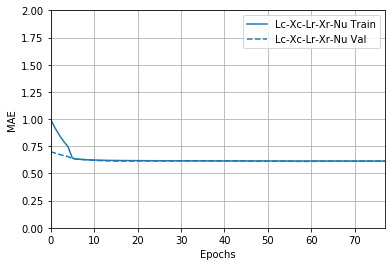

In [44]:
histories['Lc-Xc-Lr-Xr-nu'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 2])
plt.ylabel('MAE')

In [45]:
model2 = build_model(len(normed_train_data2.keys()),activ,learn)

early_history2 = model2.fit(normed_train_data2, train_labels2, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,val_labels2], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:10.9658,  mae:1.8123,  mse:10.9658,  val_loss:1.6682,  val_mae:0.8571,  val_mse:1.6682,  
..............................................................................

Text(0, 0.5, 'MAE')

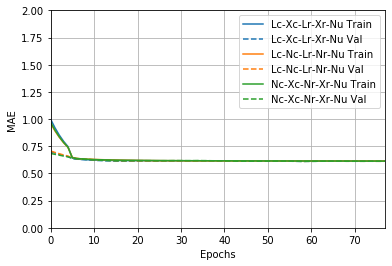

In [53]:
histories['Lc-Nc-Lr-nr-nu'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 2])
plt.ylabel('MAE')

In [47]:
model3 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history3 = model3.fit(normed_train_data3, train_labels3, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,val_labels3], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:12.3178,  mae:1.8933,  mse:12.3178,  val_loss:1.4780,  val_mae:0.7619,  val_mse:1.4780,  
..............................................................................

Text(0, 0.5, 'MAE')

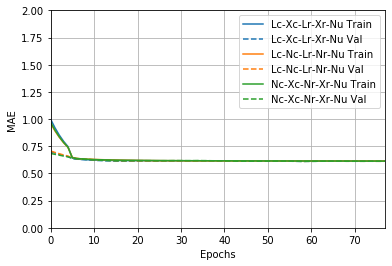

In [54]:
histories['Nc-Xc-Nr-Xr-nu'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 2])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE of AU')

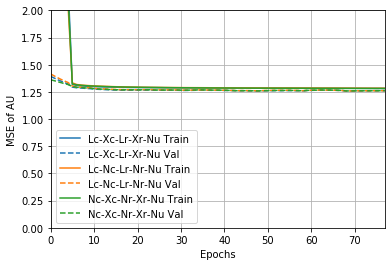

In [55]:
plotter.plot(histories, metric = "mse")
plt.ylim([0, 2])
plt.ylabel('MSE of AU')

In [50]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, test_labels1, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

102251/102251 - 2s - loss: 1.1487 - mae: 0.5851 - mse: 1.1487
Testing set for model 1, Mean Abs Error:    0.58509


In [51]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, test_labels2, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

102251/102251 - 2s - loss: 1.1500 - mae: 0.5834 - mse: 1.1500
Testing set for model 2, Mean Abs Error:              0.58339


In [52]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, test_labels3, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:30.5f}".format(mae3))

102251/102251 - 2s - loss: 1.1470 - mae: 0.5839 - mse: 1.1470
Testing set for model 3, Mean Abs Error:                        0.58390


# Make predictions

Finally, predict the fall velocity values using data in the testing set:

In [56]:
model1.predict(normed_test_data1)

array([[-25.349787 , -24.520288 ,   7.0607867, -15.487093 ],
       [-25.347067 , -24.489105 ,   7.0665107, -15.47515  ],
       [-25.213924 , -24.203236 ,   7.0875363, -15.328239 ],
       ...,
       [-23.561842 , -15.325553 ,   2.070857 ,   3.876159 ],
       [-23.780945 , -15.458529 ,   1.768123 ,   3.7059782],
       [-24.328537 , -15.862695 ,   0.8924819,   3.23186  ]],
      dtype=float32)

In [57]:
type(test_labels1)

pandas.core.frame.DataFrame

In [58]:
test_true_au = np.exp(test_labels1.pop('auto'))
test_true_ac = np.exp(test_labels1.pop('accr'))

test_true_sc_cloud = np.exp(test_labels1.pop('selfc'))
test_true_sc_rain  = np.exp(test_labels1.pop('selfr'))


In [59]:
test_predict1 = np.exp(model1.predict(normed_test_data1))
type(test_predict1)

numpy.ndarray

In [60]:
test_predict1_au = test_predict1[:,0]
test_predict1_ac = test_predict1[:,1]

test_predict1_sc_cloud = test_predict1[:,2]
test_predict1_sc_rain  = test_predict1[:,3]


In [61]:
test_predict2 = np.exp(model2.predict(normed_test_data2))

test_predict2_au = test_predict2[:,0]
test_predict2_ac = test_predict2[:,1]

test_predict2_sc_cloud = test_predict2[:,2]
test_predict2_sc_rain  = test_predict2[:,3]

In [62]:
test_predict3 = np.exp(model3.predict(normed_test_data3))

test_predict3_au = test_predict3[:,0]
test_predict3_ac = test_predict3[:,1]

test_predict3_sc_cloud = test_predict3[:,2]
test_predict3_sc_rain  = test_predict3[:,3]

In [63]:
len(test_true_au)

102251

In [64]:
test_predict1_au

array([9.7887557e-12, 9.8154158e-12, 1.1213257e-11, ..., 5.8508913e-11,
       4.6996650e-11, 2.7180074e-11], dtype=float32)

In [65]:
test_true_au

303        1.662629e-11
304        3.872501e-12
312        1.663980e-11
322        9.523963e-11
323        5.633435e-12
               ...     
2796070    1.595259e-10
2796071    3.189343e-11
2796072    6.428141e-11
2796073    7.486359e-11
2796076    2.462901e-12
Name: auto, Length: 102251, dtype: float32

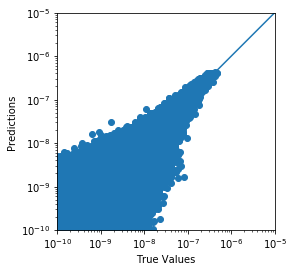

In [66]:
amin, amax = 1e-10, 1e-5

a = plt.axes(aspect='equal')
plt.scatter(test_true_au, test_predict1_au)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

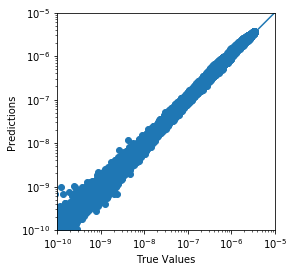

In [67]:
amin, amax = 1e-10, 1e-5

a = plt.axes(aspect='equal')
plt.scatter(test_true_ac, test_predict1_ac)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

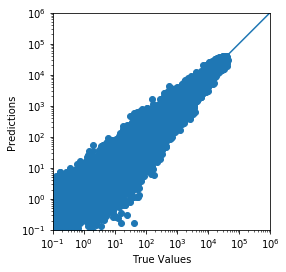

In [68]:
amin, amax = 1e-1, 1e6

a = plt.axes(aspect='equal')
plt.scatter(test_true_sc_cloud, test_predict1_sc_cloud)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

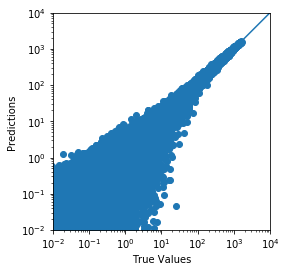

In [69]:
amin, amax = 1e-2, 1e4

a = plt.axes(aspect='equal')
plt.scatter(test_true_sc_rain, test_predict1_sc_rain)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Compare with SB2001 and KK2000

In [70]:
test_dataset1.describe()

Lc             Xc             Lr             Xr  \
count  102251.000000  102251.000000  102251.000000  102251.000000   
mean       -8.173966     -25.732601     -10.172183     -18.789951   
std         1.062508       0.499927       2.435260       2.183631   
min       -14.928525     -28.042217     -19.182032     -22.032505   
25%        -8.566163     -26.119614     -12.031308     -20.636971   
50%        -8.115712     -25.815695      -9.663490     -19.251991   
75%        -7.444825     -25.337846      -8.156309     -17.271407   
max        -6.503551     -24.882586      -6.504339     -10.191885   

                  nu  
count  102251.000000  
mean        1.965824  
std         1.109884  
min         0.500000  
25%         0.500000  
50%         1.500000  
75%         2.500000  
max         3.500000

In [71]:
qc  = np.exp(np.array(test_dataset1.Lc))
qr  = np.exp(np.array(test_dataset1.Lr))
xc  = np.exp(np.array(test_dataset1.Xc))
xr  = np.exp(np.array(test_dataset1.Xr))

nue = np.array(test_dataset1.nu)

tau2 = qr/(qc+qr+1e-15)

## SB2001 autoconversion rate, original and re-trained on current data

In [72]:
kcc = 9.44e9      # Long kernel in m3 kg-2 s-1 
kcr = 5.78        # Long kernel in m3 kg-1 s-1 
xstar = 2.6e-10   # xstar in kg

# autoconversion

au = kcc/(20*xstar) * (nue+2.0)*(nue+4.0)/(nue+1.0)**2 * qc**2 * xc**2

a1 = 600.
p1 = 0.68
taup = np.power(tau2,p1)
phi1 = a1 * taup * (1.0 - taup)**3

a2 = 954.
p2 = 0.773
taup = np.power(tau2,p2)
phi2 = a2 * taup * (1.0 - taup)**3

test_predict_sb1_au = au * phi1
test_predict_sb2_au = au * phi2

# accretion

phi = (tau2 / (tau2 + 5e-4))**4

test_predict_sb_ac = kcr * qc * qr * phi

test_predict_sb_sc_cloud = kcc * (nue+2)/(nue+1) * qc*qc - 2/xstar * test_predict_sb2_au

test_predict_sb_sc_rain  = kcr * qr * qr / xr   # = kcr * qr * nr  

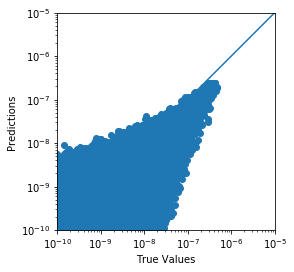

In [73]:
amin, amax = 1e-10, 1e-5

a = plt.axes(aspect='equal')
plt.scatter(test_true_au, test_predict_sb1_au)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

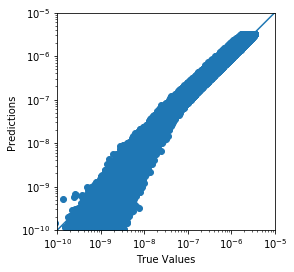

In [74]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_ac, test_predict_sb_ac)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

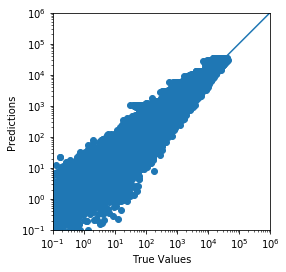

In [75]:
amin, amax = 1e-1, 1e6

a = plt.axes(aspect='equal')
plt.scatter(test_true_sc_cloud, test_predict_sb_sc_cloud)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

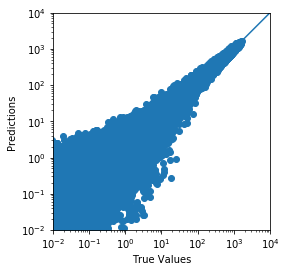

In [76]:
amin, amax = 1e-2, 1e4

a = plt.axes(aspect='equal')
plt.scatter(test_true_sc_rain, test_predict_sb_sc_rain)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## Power law regression models

KK2000 and from notebook 'McSnow_autocon_powerlaws'

In [77]:
fac = 7.540743e+13 
a = 2.786325 
b = -1.620419 
c = -0.808443 

nc = qc/xc

test_predict_pwr_au = fac * np.power(qc,a) * np.power(nc,b) * np.power(nue+1,c)  

test_predict_kk_au  = 1350. * np.power(qc,2.47) * np.power(nc*1e-6,-1.79)  # Nc in CGS

# Here we use KK2000
fac = 6.7e1
a = 1.15
b = 1.15

# AU = fac * Lc**a * Nc**b * nu**c
test_predict_pwr_ac = fac * np.power(qc,a) * np.power(qr,b) 

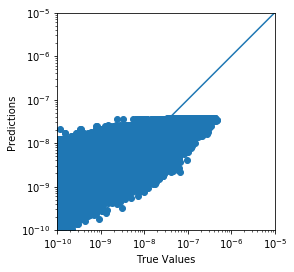

In [78]:
amin, amax = 1e-10, 1e-5

a = plt.axes(aspect='equal')
plt.scatter(test_true_au, test_predict_kk_au)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

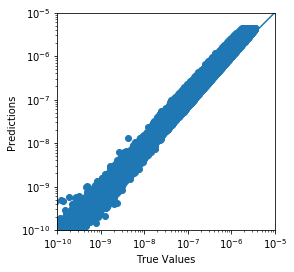

In [79]:

a = plt.axes(aspect='equal')
plt.scatter(test_true_ac, test_predict_pwr_ac)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## Final statistics 

In [80]:
def mean_abs_error(au, auTrue):  
    return np.mean(np.abs(au - auTrue))

def mean_sqr_error(au, auTrue):    
    return np.sqrt(np.mean((au - auTrue)**2))                   

In [96]:
mae1 = mean_abs_error(test_predict1_au,test_true_au)
mae2 = mean_abs_error(test_predict2_au,test_true_au)
mae3 = mean_abs_error(test_predict3_au,test_true_au)

maeSB1 = mean_abs_error(test_predict_sb1_au,test_true_au)
maeSB2 = mean_abs_error(test_predict_sb2_au,test_true_au)
maeKK  = mean_abs_error(test_predict_kk_au, test_true_au)
maePwr = mean_abs_error(test_predict_pwr_au,test_true_au)

mse1 = mean_sqr_error(test_predict1_au,test_true_au)
mse2 = mean_sqr_error(test_predict2_au,test_true_au)
mse3 = mean_sqr_error(test_predict3_au,test_true_au)

mseSB1 = mean_sqr_error(test_predict_sb1_au,test_true_au)
mseSB2 = mean_sqr_error(test_predict_sb2_au,test_true_au)
mseKK  = mean_sqr_error(test_predict_kk_au, test_true_au)
msePwr = mean_sqr_error(test_predict_pwr_au,test_true_au)

mae = [ mae1, mae2, mae3, maeSB1, maeSB2, maeKK, maePwr ]
mse = [ mse1, mse2, mse3, mseSB1, mseSB2, mseKK, msePwr ]

In [97]:
mae

[2.564809697958026e-09,
 2.563668610733316e-09,
 2.5036572814940428e-09,
 3.842622664507189e-09,
 3.202986320616219e-09,
 5.782359480122068e-09,
 5.063335084543041e-09]

In [98]:
labels = list(histories.keys())
labels.append('SB2001')
labels.append('SB new')
labels.append('KK2000')
labels.append('Power')
labels

['Lc-Xc-Lr-Xr-nu',
 'Lc-Nc-Lr-nr-nu',
 'Nc-Xc-Nr-Xr-nu',
 'SB2001',
 'SB new',
 'KK2000',
 'Power']

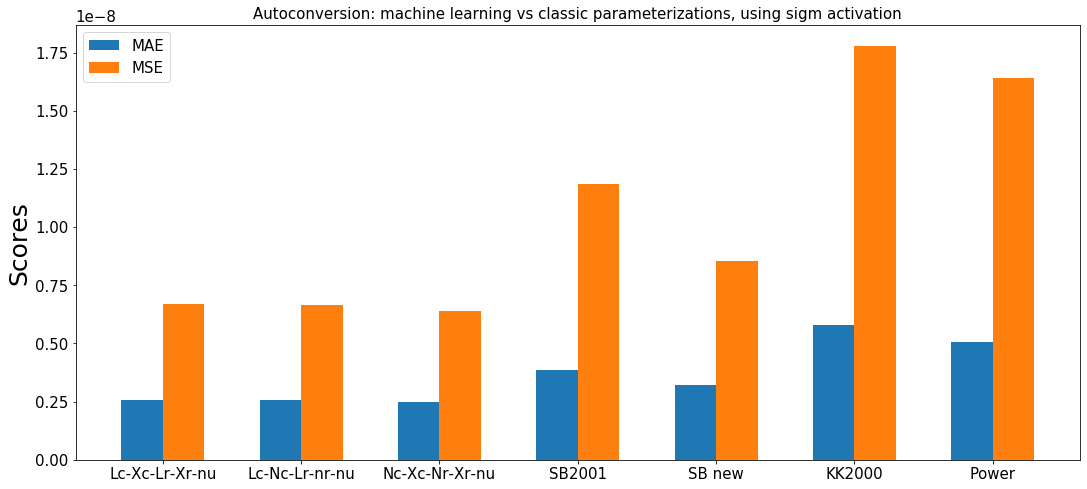

In [99]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mae, width, label='MAE')
rects2 = ax.bar(x + width/2, mse, width, label='MSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Autoconversion: machine learning vs classic parameterizations, using '+activ+' activation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

In [100]:
fig.savefig("autocon_one4all_v9_barplot_"+activ+"_"+data+".png", bbox_inches='tight', dpi=600)

In [101]:
mae1 = mean_abs_error(test_predict1_ac,test_true_ac)
mae2 = mean_abs_error(test_predict2_ac,test_true_ac)
mae3 = mean_abs_error(test_predict3_ac,test_true_ac)

maeSB1 = mean_abs_error(test_predict_sb_ac,test_true_ac)
maePwr = mean_abs_error(test_predict_pwr_ac,test_true_ac)

mse1 = mean_sqr_error(test_predict1_ac,test_true_ac)
mse2 = mean_sqr_error(test_predict2_ac,test_true_ac)
mse3 = mean_sqr_error(test_predict3_ac,test_true_ac)

mseSB1 = mean_sqr_error(test_predict_sb_ac,test_true_ac)
msePwr = mean_sqr_error(test_predict_pwr_ac,test_true_ac)

mae = [ mae1, mae2, mae3, maeSB1, maePwr ]
mse = [ mse1, mse2, mse3, mseSB1, msePwr ]

In [102]:
labels = list(histories.keys())
labels.append('SB2001')
labels.append('KK2000')
labels

['Lc-Xc-Lr-Xr-nu', 'Lc-Nc-Lr-nr-nu', 'Nc-Xc-Nr-Xr-nu', 'SB2001', 'KK2000']

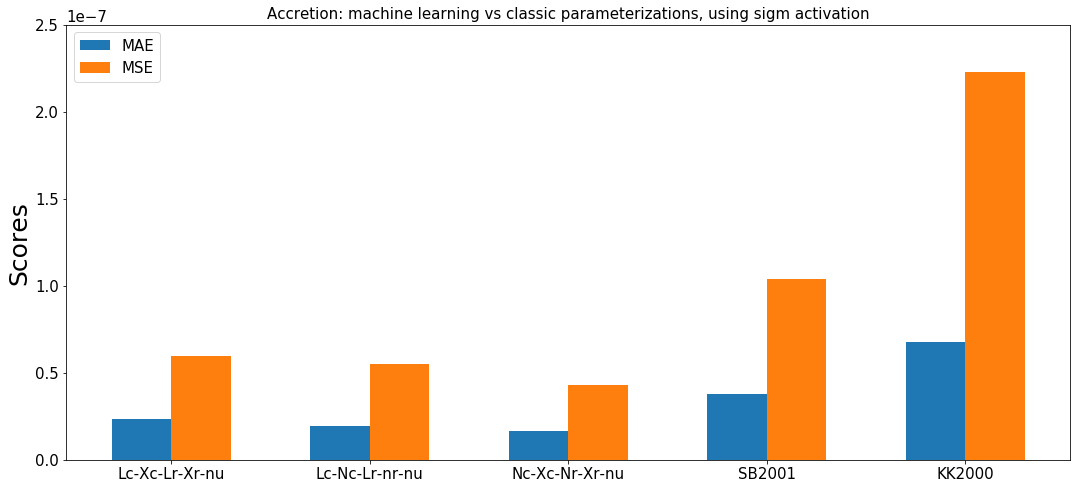

In [104]:
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mae, width, label='MAE')
rects2 = ax.bar(x + width/2, mse, width, label='MSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Accretion: machine learning vs classic parameterizations, using '+activ+' activation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,2.5e-7)
ax.legend()

#fig.tight_layout()

plt.show()

In [105]:
fig.savefig("accretion_one4all_v9_barplot_"+activ+"_"+data+".png", bbox_inches='tight', dpi=600)

# Save models to file

In [107]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v9
   
model1.save('saved_model_v9/one4all_LcXcLrXrNu_01_'+activ+'_'+DNNstring+'_'+data) 
model2.save('saved_model_v9/one4all_LcNcLrNrNu_01_'+activ+'_'+DNNstring+'_'+data) 
model3.save('saved_model_v9/one4all_NcXcNrXrNu_01_'+activ+'_'+DNNstring+'_'+data) 

# save train_stats for normalization of input data in Pandas pickle format
train_stats1.to_pickle('saved_model_v9/one4all_LcXcLrXrNu_01_'+activ+'_'+DNNstring+'_'+data+'_norm.pickle')
train_stats2.to_pickle('saved_model_v9/one4all_LcNcLrNrNu_01_'+activ+'_'+DNNstring+'_'+data+'_norm.pickle')
train_stats3.to_pickle('saved_model_v9/one4all_NcXcNrXrNu_01_'+activ+'_'+DNNstring+'_'+data+'_norm.pickle')


INFO:tensorflow:Assets written to: saved_model_v9/one4all_LcXcLrXrNu_01_sigm_32x32x32_big_n5_z12/assets
INFO:tensorflow:Assets written to: saved_model_v9/one4all_LcNcLrNrNu_01_sigm_32x32x32_big_n5_z12/assets
INFO:tensorflow:Assets written to: saved_model_v9/one4all_NcXcNrXrNu_01_sigm_32x32x32_big_n5_z12/assets
